In [1]:
#libraries
import os 
import pandas as pd
import numpy as np 
import h5py
import math
import collections
import filecmp
from lxml import etree as ET
#import xml.etree.ElementTree as ET
import datetime
from collections import OrderedDict
#import pandasql as ps
from operator import itemgetter
import csv
from collections import Counter
#from google.colab import drive

import geopandas as gpd
#import pandasql as ps
import matplotlib.pyplot as plt
#import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy
import fiona

from scipy.stats import kstest
from scipy.stats import mannwhitneyu

#from dill.source import getsource
import json

# load csv module
import csv

In [224]:
os.chdir('G:/My Drive/2021/Bias/PSRC_od_simulation_2018')

In [534]:
#packages
#psrc data reading
def h5_to_data_frame(h5file, table_name):
    table = h5file[table_name]
    col_dict = {}
    #cols = ['hhno', 'hhtaz']
    for col in table.keys():
        if col == 'sov_ff_time':
            pass
        else:
            my_array = np.asarray(table[col]).astype('int')
        col_dict[col] = my_array.astype('int')
    return(pd.DataFrame(col_dict))


#process fcd dt
def get_sim(path, fcd_dt_path, stays_path):
    fcd_out = pd.read_csv(path+fcd_dt_path, header=None)
    fcd_out.columns = ['id', 'taz', 'time']

    revise_dt = lambda x: x.split('-')[0] if '-' in x else x
    get_sample_index = lambda x: x.split('-')[2] if '-' in x else 3

    fcd_out['reids'] = fcd_out['id'].apply(revise_dt)
    fcd_out['sample_index'] = (fcd_out['id'].apply(get_sample_index)).astype(int)
    fcd_out.head(3)

    print((fcd_out.groupby(by=['reids', 'sample_index']).size().to_frame().reset_index()).groupby(['sample_index']).size())

    #check the index
    print(np.unique(fcd_out['sample_index']))

    #select the ids
    select_ids = np.unique(fcd_out['reids'][fcd_out['sample_index']==1])

    #only select stay instead of stay left
    stays_ = pd.read_csv(path+stays_path, header=None)
    stays_.columns = ['reids', 'taz']

    select_ids = list(select_ids)
    for i in stays_['reids']:
        if i in select_ids:
            print(i)
        else:
            select_ids.append(i)
    return(select_ids)


# get psrc data and total dt based on psrc
def get_demo_col(demo_col, input_person, add_text):
    num_demo = len(np.unique(input_person[demo_col]))
    col_name = ['taz']
    for i in range(num_demo):
        col_name.append(add_text+str(i))
    return(col_name)

def convert_demo_sum2col(demo_col, input_person, col_text, pop_col):
    person_dt = input_person.groupby(by=['taz', demo_col]).size().to_frame()
    person_dt.reset_index(inplace=True)

    person_dt = person_dt.pivot(index=['taz'], columns=demo_col, values=[0])
    person_dt.columns = person_dt.columns.droplevel()
    person_dt = person_dt.rename_axis(None, axis=1)
    person_dt.reset_index(inplace=True)

    person_dt = person_dt.replace(np.nan, 0)
    person_dt.columns = get_demo_col(demo_col, input_person, col_text)
    
    col_name = person_dt.columns
    person_dt[pop_col] = np.sum(person_dt[col_name[1:]], axis=1)

    return(person_dt)

def get_selected_area_dt(dt, selected_taz):
    dt = dt[dt['taz'].isin(selected_taz)]
    return(dt)

In [123]:
#hdf_file = h5py.File(r'daysim_outputs.h5', "r")
# output_dir = r'\\modelstation3\c$\\Workspace\sc_new_emp_SCEN3_2018'
# print(hdf_file.keys())

#test dataset for BI
test_dt = pd.read_csv('demo_group_dt_land_use_hm.csv', index_col=0)

#person info
person = pd.read_csv('per_with_demo.csv')
person['taz'] = person['zone_id']+1

#selected tazs in sumo
path= 'G:/My Drive/2021/Bias/SUMO_simulation/MatSumo-main/SUMO/SUMO_network/'
datafile = 'Taz_with_pseudo_link.add.xml'
tree = ET.parse(path+datafile)
root = tree.getroot()
selected_taz = []
for taz in root.findall('taz'):
    tazid = taz.get('id')
    #filter out pseudo taz
    if len(tazid) <=3:
        selected_taz.append(int(tazid))
             
        
#check cuebiq home data
psrc_cuebiq = pd.read_csv(path+'home_cuebiq_taz.csv')
psrc_cuebiq = psrc_cuebiq.groupby(by=['TAZ']).size().to_frame()
psrc_cuebiq.reset_index(inplace=True)

psrc_cuebiq.columns = ['TAZ', 'app_count']
#the count equals to the appid_count in test dt
#however, the test dt losses some infomation

<KeysViewHDF5 ['Household', 'HouseholdDay', 'Person', 'PersonDay', 'Tour', 'Trip']>


In [ ]:
#get psrc total vs taz
print('# of tazs covered in person dt', len(np.unique(person['taz'])))
print('# of tazs covered in psrc cuebiq and person dt',len(np.unique(person['taz'][person['taz'].isin(psrc_cuebiq['TAZ'])])))

#get raw data with all psrc tazs
person_BI_all = convert_demo_sum2col('demo_num', person, 'd', 'pop')
person_BI_all = psrc_cuebiq.set_index('TAZ').join(person_BI_all.set_index('taz'))
person_BI_all.reset_index(inplace=True)

person_BI_all = person_BI_all.replace(np.nan, 0)
person_BI_all = person_BI_all[person_BI_all['pop']!= 0]

person_BI_all = (person_BI_all.set_index('TAZ')).join((convert_demo_sum2col('demo_noage', person, 'dng')).set_index('taz'))
person_BI_all.reset_index(inplace=True)
person_BI_all.to_csv('person_BI_all.csv')

In [541]:
#create dataset for sim dt
#simulation data in sumo
path = "G:/My Drive/2021/Bias/sumo_simulation/appsim/"
#os.listdir(path)csv_path = '../data-1670309862526.csv'

fcd_dt_path = 'fcd_output_10per_all_30sec.csv'
stays_path = 'staysall.csv'

fcd_dt_path_ht = 'fcd_output_10per_ht_30sec.csv'
stays_path_ht = 'stays.csv'

sim_all_ids = get_sim(path, fcd_dt_path, stays_path)
sim_ht_ids = get_sim(path, fcd_dt_path_ht, stays_path_ht)

person_sim_all = get_selected_area_dt((convert_demo_sum2col('demo_num', person[person['person_id'].isin(sim_all_ids)], 'd', 'sim_all')), 
                                     selected_taz)
person_sim_ht = get_selected_area_dt((convert_demo_sum2col('demo_num', person[person['person_id'].isin(sim_ht_ids)], 'd', 'sim_ht')),
                                    selected_taz)


person_BI_sumo_sim = ((person_BI_all[person_BI_all['TAZ'].isin(selected_taz)]).set_index('TAZ')).join((person_sim_all[['taz','sim_all']]).set_index('taz'))
person_BI_sumo_sim.reset_index(inplace=True)
person_BI_sumo_sim = (person_BI_sumo_sim.set_index('TAZ')).join((person_sim_ht[['taz','sim_ht']]).set_index('taz'))
person_BI_sumo_sim.reset_index(inplace=True)
person_BI_sumo_sim = person_BI_sumo_sim.replace(np.nan, 0)

person_BI_sumo_sim.to_csv('person_BI_sumo_sim.csv')

(116, 50)
KstestResult(statistic=0.1206896551724138, pvalue=0.3681092757882149)
MannwhitneyuResult(statistic=7434.5, pvalue=0.16697158843083526)
(124, 50)
KstestResult(statistic=0.16129032258064516, pvalue=0.07936465968200286)
MannwhitneyuResult(statistic=8767.5, pvalue=0.05594885540618503)


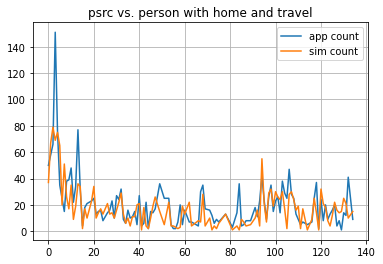

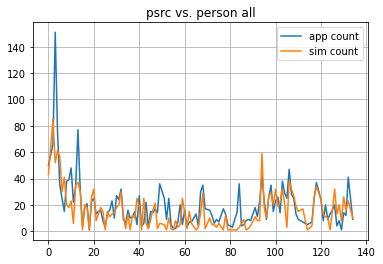

In [548]:
#raw dt vs. sim dt (cuebiq vs. sumo sim in the tested area)
plt.figure('1')
test = person_BI_sumo_sim[person_BI_sumo_sim['sim_ht']!=0]
print(test.shape)
plt.title('psrc vs. person with home and travel')
plt.plot(test['app_count'], label = 'app count')
plt.plot(test['sim_ht'], label='sim count')
plt.legend()
plt.grid()
print(kstest(test['app_count'], test['sim_ht']))
print(mannwhitneyu(test['app_count'], test['sim_ht']))

plt.figure('2')
plt.title('psrc vs. person all')
test = person_BI_sumo_sim[person_BI_sumo_sim['sim_all']!=0]
print(test.shape)
plt.plot(test['app_count'], label = 'app count')
plt.plot(test['sim_all'], label='sim count')
plt.legend()
plt.grid()
print(kstest(test['app_count'], test['sim_all']))
print(mannwhitneyu(test['app_count'], test['sim_all']))